In [1]:
import importlib
import os
from joblib import dump, load

import numpy as np
import pandas as pd

import ml.explo as mlexplo
import ml.prepare as mlprepare

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import metrics

data_path = "..\\data\\stackoverflow\\"
model_path = data_path + "models\\"
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = "{:,.2f}".format

In [2]:
def prepare_baseline_ys(df, tags, col):
    ret =  dict({})
    for tag in tags.index:
        sr_tag = df[col].copy(deep=True)
        sr_tag = sr_tag.apply(lambda x: 1 if tag in x else 0)
        ret[tag] = sr_tag
    return ret

init_y = False
if init_y:
    df_top = pd.read_pickle(data_path + 'Top_Tags.pkl')
    df_top_test = pd.read_pickle(data_path + 'Top_Tags_test.pkl')
    
    tags_10 = mlprepare.prepare_multi_label(df_top,'Tags_T10')
    y_dict_10 = prepare_baseline_ys(df_top, tags_10, 'Tags_T10')
    dump(y_dict_10, data_path + 'baseline_y_top10.joblib')
    tags_10_test = mlprepare.prepare_multi_label(df_top_test,'Tags_T10')
    y_dict_10_test = prepare_baseline_ys(df_top_test, tags_10_test, 'Tags_T10')
    dump(y_dict_10_test, data_path + 'baseline_y_top10_test.joblib')

    tags_50 = mlprepare.prepare_multi_label(df_top,'Tags_T50')
    y_dict_50 = prepare_baseline_ys(df_top, tags_50, 'Tags_T50')
    dump(y_dict_50, data_path + 'baseline_y_top50.joblib')
    tags_50_test = mlprepare.prepare_multi_label(df_top_test,'Tags_T50')
    y_dict_50_test = prepare_baseline_ys(df_top_test, tags_50_test, 'Tags_T50')
    dump(y_dict_50_test, data_path + 'baseline_y_top50_test.joblib')

    tags_100 = mlprepare.prepare_multi_label(df_top,'Tags_T100')
    y_dict_100 = prepare_baseline_ys(df_top, tags_100, 'Tags_T100')
    dump(y_dict_100, data_path + 'baseline_y_top100.joblib')
    tags_100_test = mlprepare.prepare_multi_label(df_top_test,'Tags_T100')
    y_dict_100_test = prepare_baseline_ys(df_top_test, tags_100_test, 'Tags_T100')
    dump(y_dict_100_test, data_path + 'baseline_y_top100_test.joblib')

In [3]:
y_dict = load(data_path + 'baseline_y_top50.joblib')
y_dict_test = load(data_path + 'baseline_y_top50_test.joblib')

title_vectorizer = load(model_path + 'stem_title_vectorizer.joblib')
body_vectorizer = load(model_path + 'stem_body_vectorizer_11.joblib')

title_corpus = load(data_path + 'stem_title_corpus.joblib')
X_title = title_vectorizer.fit_transform(title_corpus)

body_corpus = load(data_path + 'stem_body_corpus.joblib')
X_body = body_vectorizer.fit_transform(body_corpus)

In [4]:
y_dict.keys()

dict_keys(['python', 'other', 'javascript', 'r', 'pandas', 'c++', 'java', 'c#', 'python-3.x', 'sql', 'dataframe', 'reactjs', 'html', 'arrays', 'regex', 'c', 'css', 'php', 'swift', 'typescript', 'node.js', 'android', 'amazon-web-services', 'numpy', 'mysql', 'jquery', 'swiftui', 'postgresql', 'json', 'django', 'vue.js', 'list', 'ios', 'string', 'dplyr', 'google-sheets', 'angular', 'mongodb', 'sql-server', 'ggplot2', 'bash', 'excel', 'powershell', 'wordpress', 'google-apps-script', 'rust', 'git', 'algorithm', 'matplotlib', 'flutter', 'firebase'])

In [4]:
body_model = load(model_path + 'top50_body_RidgeC_baseline.joblib')
title_model = load(model_path + 'top50_title_RidgeC_baseline.joblib')

In [42]:
txt = 'help array  df'
tag = 'python'
title_tv = title_vectorizer.transform([txt])
body_tv = body_vectorizer.transform([txt])
print ("Reverse : ", body_vectorizer.inverse_transform(body_tv))
# print ('Should I tag python?', clf.predict(tv))
print ('Title_model:', title_model[tag].predict(title_tv))
print ('Body_model:', body_model[tag].predict(body_tv))
print ('Body_model:', clf.predict(body_tv))



Reverse :  [array(['help', 'df', 'array'], dtype='<U23')]
Title_model: [0]
Body_model: [0]


In [5]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X_body, y_dict['python'], 
#                                                         random_state=42,
                                                        test_size=0.2, shuffle=True)

clf = RandomForestClassifier(n_jobs=6)
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=6)

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
score = clf.predict_proba(X_test)
fpr, tpr, th = roc_curve(y_test, score[:,1])

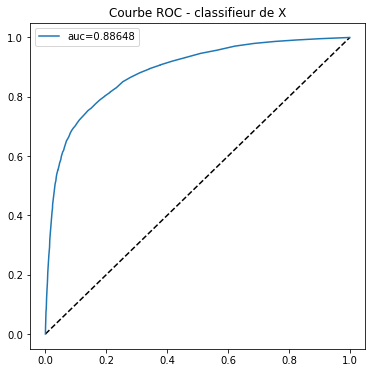

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)
ax.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur de X')
ax.legend();

In [10]:
params = {
    'alpha': np.arange(10)*.1+.05,
    'max_iter': [25],
    'solver': ['sag']

    }

gs_clf = GridSearchCV(
    RidgeClassifier(),
    params,
    n_jobs=6)

for count in (np.arange(10)+1)*5000:
    gs_clf.fit(X_train[:count], y_train[:count])
    print(gs_clf.best_estimator_)
    print(gs_clf.best_estimator_.score(X_test, y_test))

RidgeClassifier(alpha=0.6500000000000001, max_iter=25, solver='sag')
0.8550611906243518
RidgeClassifier(alpha=0.9500000000000001, max_iter=25, solver='sag')
0.8600394109105994
RidgeClassifier(alpha=0.45, max_iter=25, solver='sag')
0.8614395353661066
RidgeClassifier(alpha=0.05, max_iter=25, solver='sag')
0.8622173822858328
RidgeClassifier(alpha=0.05, max_iter=25, solver='sag')
0.8618025305953122
RidgeClassifier(alpha=0.15000000000000002, max_iter=25, solver='sag')
0.8627359468989836
RidgeClassifier(alpha=0.05, max_iter=25, solver='sag')
0.8636693632026551
RidgeClassifier(alpha=0.05, max_iter=25, solver='sag')
0.8636693632026551
RidgeClassifier(alpha=0.05, max_iter=25, solver='sag')
0.8636693632026551
RidgeClassifier(alpha=0.15000000000000002, max_iter=25, solver='sag')
0.8635137938187099


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_body, y_dict['python'], random_state=42, test_size=0.2, shuffle=True)
params = {
    'alpha': np.arange(10)*.1+.1,
    'max_iter': [20],
    'solver': ['sag']
    }
clf = GridSearchCV(
    RidgeClassifier(),
    params,
    n_jobs=6)
clf.fit(X_train, y_train)
clf.best_estimator_

RidgeClassifier(alpha=0.1, max_iter=20, solver='sag')

In [12]:
clf.classes_

array([0, 1], dtype=int64)

In [13]:
clf.best_estimator_.score(X_test, y_test)

0.8614395353661066

In [14]:
dump(clf.best_estimator_, data_path + 'baseline_python.joblib')

['..\\data\\stackoverflow\\baseline_python.joblib']

[array(['on', 'need', 'help', 'dict'], dtype='<U674')]

In [8]:
params = {
    'alpha': np.arange(10)*.1+.1,
    'max_iter': [25],
    }
clf = GridSearchCV(
    RidgeClassifier(),
    params,
    n_jobs=6)

baseline =  dict({})

for k in y_dict.keys():
    print("classifying:", k)
    X_train, X_test, y_train, y_test = train_test_split(X_body, y_dict[k], random_state=42, test_size=0.2, shuffle=True)
#     X_train, X_test, y_train, y_test = train_test_split(X_title, y_dict[k], random_state=42, test_size=0.2, shuffle=True)
#     clf = RidgeClassifier().fit(X_train, y_train)
    clf = GridSearchCV(
        RidgeClassifier(),
        params,
        n_jobs=6)
    clf.fit(X_train, y_train)
    baseline[k] = clf.best_estimator_
    print("GS best:", clf.best_estimator_)
    print("clf score: ", clf.best_estimator_.score(X_test, y_test))
    pred = clf.best_estimator_.predict(X_test)
    f1 = metrics.f1_score(y_test, pred)
    precision = metrics.precision_score(y_test, pred)
    recall = metrics.recall_score(y_test, pred)
    print("F1:   %0.3f, precision: %0.3f, recall: %0.3f" % (f1, precision, recall))
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))
    print("=========================")
dump(baseline, model_path + 'body_ridgeClassifier.joblib')

classifying: python
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.8606616884463805
F1:   0.518, precision: 0.775, recall: 0.388
confusion matrix:
[[15156   418]
 [ 2269  1441]]
classifying: other
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.8754926363824933
F1:   0.191, precision: 0.742, recall: 0.110
confusion matrix:
[[16599    99]
 [ 2302   284]]
classifying: javascript
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9084733457788841
F1:   0.398, precision: 0.743, recall: 0.272
confusion matrix:
[[16936   202]
 [ 1563   583]]
classifying: r
GS best: RidgeClassifier(alpha=0.2, max_iter=25)
clf score:  0.9347127152043144
F1:   0.370, precision: 0.731, recall: 0.247
confusion matrix:
[[17656   136]
 [ 1123   369]]
classifying: pandas
GS best: RidgeClassifier(alpha=0.6, max_iter=25)
clf score:  0.9561812901887575
F1:   0.627, precision: 0.838, recall: 0.500
confusion matrix:
[[17730   137]
 [  708   709]]
classifying: c++
GS best: RidgeC

C:\Users\vince\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9654117403028417
F1:   0.343, precision: 0.633, recall: 0.235
confusion matrix:
[[18443   101]
 [  566   174]]
classifying: dataframe
GS best: RidgeClassifier(alpha=0.8, max_iter=25)
clf score:  0.9597593860194981
F1:   0.248, precision: 0.542, recall: 0.161
confusion matrix:
[[18380   108]
 [  668   128]]
classifying: reactjs
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9767683053308442
F1:   0.562, precision: 0.875, recall: 0.414
confusion matrix:
[[18549    41]
 [  407   287]]
classifying: html
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9664488695291433
F1:   0.247, precision: 0.609, recall: 0.155
confusion matrix:
[[18531    68]
 [  579   106]]
classifying: arrays
GS best: RidgeClassifier(alpha=0.7000000000000001, max_iter=25)
clf score:  0.9715308027380212
F1:   0.288, precision: 0.613, recall: 0.188
confusion matrix:
[[18624    70]
 [  479   111]]
classifying: regex
GS best: Ridge

C:\Users\vince\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GS best: RidgeClassifier(alpha=0.6, max_iter=25)
clf score:  0.9874507363617506
F1:   0.424, precision: 0.679, recall: 0.308
confusion matrix:
[[18953    42]
 [  200    89]]
classifying: django
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9920141049574777
F1:   0.586, precision: 0.852, recall: 0.447
confusion matrix:
[[19021    19]
 [  135   109]]
classifying: vue.js
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9927400954158888
F1:   0.595, precision: 0.981, recall: 0.427
confusion matrix:
[[19041     2]
 [  138   103]]
classifying: list
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9859468989836133
F1:   0.015, precision: 0.667, recall: 0.007
confusion matrix:
[[19011     1]
 [  270     2]]
classifying: ios
GS best: RidgeClassifier(alpha=0.9, max_iter=25)
clf score:  0.9862061812901888
F1:   0.043, precision: 0.400, recall: 0.023
confusion matrix:
[[19012     9]
 [  257     6]]
classifying: string
GS best: RidgeClassifier(alpha=0.1,

C:\Users\vince\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9874507363617506
F1:   0.000, precision: 0.000, recall: 0.000
confusion matrix:
[[19042     0]
 [  242     0]]
classifying: google-sheets


C:\Users\vince\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9912881144990666
F1:   0.543, precision: 0.746, recall: 0.427
confusion matrix:
[[19016    34]
 [  134   100]]
classifying: angular
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9914436838830119
F1:   0.466, precision: 0.837, recall: 0.323
confusion matrix:
[[19047    14]
 [  151    72]]
classifying: mongodb
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9938809375648205
F1:   0.546, precision: 0.910, recall: 0.390
confusion matrix:
[[19095     7]
 [  111    71]]
classifying: sql-server
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9903546981953951
F1:   0.000, precision: 0.000, recall: 0.000
confusion matrix:
[[19098     3]
 [  183     0]]
classifying: ggplot2
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9904584111180254
F1:   0.032, precision: 0.429, recall: 0.016
confusion matrix:
[[19097     4]
 [  180     3]]
classifying: bash
GS best: RidgeClassifier(

C:\Users\vince\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GS best: RidgeClassifier(alpha=0.6, max_iter=25)
clf score:  0.9961626218626841
F1:   0.745, precision: 0.885, recall: 0.643
confusion matrix:
[[19102    14]
 [   60   108]]
classifying: algorithm
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.990925119269861
F1:   0.093, precision: 0.409, recall: 0.053
confusion matrix:
[[19100    13]
 [  162     9]]
classifying: matplotlib
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9919622484961627
F1:   0.000, precision: 0.000, recall: 0.000
confusion matrix:
[[19129     0]
 [  155     0]]
classifying: flutter


C:\Users\vince\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9907695498859158
F1:   0.022, precision: 0.286, recall: 0.011
confusion matrix:
[[19104     5]
 [  173     2]]
classifying: firebase
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9937772246421904
F1:   0.487, precision: 0.731, recall: 0.365
confusion matrix:
[[19107    21]
 [   99    57]]


['..\\data\\stackoverflow\\models\\body_ridgeClassifier.joblib']

In [9]:
params = {
    'alpha': np.arange(10)*.1+.1,
    'max_iter': [25],
    }
clf = GridSearchCV(
    RidgeClassifier(),
    params,
    n_jobs=6)

baseline =  dict({})

for k in y_dict.keys():
    print("classifying:", k)
    X_train, X_test, y_train, y_test = train_test_split(X_title, y_dict[k], random_state=42, test_size=0.2, shuffle=True)
#     X_train, X_test, y_train, y_test = train_test_split(X_title, y_dict[k], random_state=42, test_size=0.2, shuffle=True)
#     clf = RidgeClassifier().fit(X_train, y_train)
    clf = GridSearchCV(
        RidgeClassifier(),
        params,
        n_jobs=6)
    clf.fit(X_train, y_train)
    baseline[k] = clf.best_estimator_
    print("GS best:", clf.best_estimator_)
    print("clf score: ", clf.best_estimator_.score(X_test, y_test))
    pred = clf.best_estimator_.predict(X_test)
    f1 = metrics.f1_score(y_test, pred)
    precision = metrics.precision_score(y_test, pred)
    recall = metrics.recall_score(y_test, pred)
    print("F1:   %0.3f, precision: %0.3f, recall: %0.3f" % (f1, precision, recall))
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))
    print("=========================")
dump(baseline, model_path + 'title_ridgeClassifier.joblib')

classifying: python
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.8936942543040863
F1:   0.661, precision: 0.854, recall: 0.540
confusion matrix:
[[15231   343]
 [ 1707  2003]]
classifying: other
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.8894420244762498
F1:   0.392, precision: 0.747, recall: 0.265
confusion matrix:
[[16466   232]
 [ 1900   686]]
classifying: javascript
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9156813939016801
F1:   0.477, precision: 0.770, recall: 0.345
confusion matrix:
[[16917   221]
 [ 1405   741]]
classifying: r
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.940209500103713
F1:   0.402, precision: 0.888, recall: 0.260
confusion matrix:
[[17743    49]
 [ 1104   388]]
classifying: pandas
GS best: RidgeClassifier(alpha=0.2, max_iter=25)
clf score:  0.9683157021364862
F1:   0.737, precision: 0.946, recall: 0.603
confusion matrix:
[[17818    49]
 [  562   855]]
classifying: c++
GS best: RidgeCl

C:\Users\vince\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9905102675793404
F1:   0.408, precision: 0.940, recall: 0.260
confusion matrix:
[[19038     4]
 [  179    63]]
classifying: google-sheets
GS best: RidgeClassifier(alpha=0.7000000000000001, max_iter=25)
clf score:  0.9933105164903547
F1:   0.670, precision: 0.834, recall: 0.560
confusion matrix:
[[19024    26]
 [  103   131]]
classifying: angular
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9942439327940261
F1:   0.674, precision: 0.975, recall: 0.516
confusion matrix:
[[19058     3]
 [  108   115]]
classifying: mongodb
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.997407176934246
F1:   0.851, precision: 0.929, recall: 0.786
confusion matrix:
[[19091    11]
 [   39   143]]
classifying: sql-server
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9908214063472308
F1:   0.102, precision: 0.714, recall: 0.055
confusion matrix:
[[19097     4]
 [  173    10]]
classifying: ggplot2
GS

['..\\data\\stackoverflow\\models\\title_ridgeClassifier.joblib']

NameError: name 'corpus_title' is not defined

In [11]:
clf = RidgeClassifier().fit(X_title, y_dict['javascript'])

In [12]:
clf.score(X_title, y_dict['javascript'])

0.9156606513171541

In [26]:
df = df_only.copy(deep=True)
corpus_title = [' '.join(map(str, w)) for w in df['Title'].tolist()]
corpus_body = [' '.join(map(str, w)) for w in df['Body'].tolist()]
corpus_tags = [' '.join(map(str, w)) for w in df['Tags'].tolist()]

In [48]:
set(corpus_title)[:50]

NameError: name 'corpus_title' is not defined